In [1]:
using Flux, Statistics
using Flux: crossentropy, throttle, logitcrossentropy
using Base.Iterators: repeated, partition, flatten
using DelimitedFiles
using LinearAlgebra
using RDatasets
using GLM
using BSON: @save, @load
using Random
using Base.Threads 
using Plots

┌ Warning: The NVIDIA driver on this system only supports up to CUDA 11.0.0.
│ For performance reasons, it is recommended to upgrade to a driver that supports CUDA 11.2 or higher.
└ @ CUDA /home/jupyter-nrmeskell/.julia/packages/CUDA/mVgLI/src/initialization.jl:42


In [2]:
filter(x->occursin("020", x), readdir("/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"))[1]

"W05__H05__A020_bars_extracted.txt"

In [3]:
function getEdepGateBarA0(number, angle)
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    angle = lpad(angle,3,"0")
    fileName = filter(x->occursin(string("A", angle), x), readdir(folder))[number]
    filePath = string(folder, fileName)
    return Int.(round.(reshape(readdlm(filePath)[4:67, 2], (8,8))))
end

getEdepGateBarA0 (generic function with 1 method)

In [4]:
function getEdepGateBarA90(number, angle)
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    angle90 = lpad(angle+90, 3, "0")
    fileName90 = filter(x->occursin(string("A", angle90), x), readdir(folder))[number]
    filePath90 = string(folder, fileName90)
    return return Int.(round.(reshape(readdlm(filePath90)[4:67,2], (8,8))))
end

getEdepGateBarA90 (generic function with 1 method)

In [5]:
#getEdepGateBarA90(1, 40)

In [6]:
function getEdepGateGrid(number, angle)
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/cubes/"
    angle = lpad(angle, 3, "0")
    fileName = filter(x->occursin(string("A", angle), x), readdir(folder))[number]
    filePath = string(folder, fileName)
    return Int.(round.(readdlm(filePath)[4:515,2]))
end

getEdepGateGrid (generic function with 1 method)

In [7]:
#getEdepGateGrid(1, 40)

dosimeter/gate_data/bars/W05__H05__A000_bars_extracted.txt

In [8]:
function getEdepOhioBarA0(number)
    folder = "/home/jupyter-nrmeskell/dosimeter/ohio_data/extracted_data/"
    fileName = filter(x->occursin(r"R...txt", x), readdir(folder))[number]
    filePath = string(folder,fileName)
    return Int.(round.(reshape(readdlm(filePath)[4:67,2], (8,8))))
end

getEdepOhioBarA0 (generic function with 1 method)

In [9]:
#getEdepOhioBarA0(1)

In [10]:
function getEdepOhioBarA90(number)
    folder = "/home/jupyter-nrmeskell/dosimeter/ohio_data/extracted_data/"
    fileName = filter(x->occursin(r"R.._r.txt", x), readdir(folder))[number]
    filePath = string(folder,fileName)
    return Int.(round.(reshape(readdlm(filePath)[4:67,2], (8,8))))
end

getEdepOhioBarA90 (generic function with 1 method)

In [11]:
#getEdepOhioBarA90(1)

In [12]:
function normalize(inputArray)
    min = minimum(inputArray)
    inputArray = (inputArray.-(min))
    max = maximum(inputArray)/1023
    inputArray = (inputArray./max).+1
    return Int.(round.(inputArray))
end

normalize (generic function with 1 method)

In [13]:
#normalize(getEdepOhioBarA90(1))

In [14]:
#normalize(getEdepOhioBarA0(1))

In [15]:
function makeTrainingData()
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    trainingSize = size(filter(x->occursin("A080", x), readdir(folder)))[1]
    trainingArray = Array{Int64}(undef, 8, 8, 2, trainingSize*20)
    
    for i = 1:trainingSize
        for r = 1:20
            trainingArray[:, :, 1, (i-1)*20 + r] = getEdepGateBarA0(i,  (r-1)*10 + 80)
            trainingArray[:, :, 2, (i-1)*20 + r] = getEdepGateBarA90(i,  (r-1)*10 + 80)
        end
    end
    
    return trainingArray
end

makeTrainingData (generic function with 1 method)

In [16]:
function makeValidationData()
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    trainingSize = size(filter(x->occursin("A000", x), readdir(folder)))[1]
    trainingArray = Array{Int64}(undef, 8, 8, 2, trainingSize*4)
    for i = 1:trainingSize
        for r = 1:4
            trainingArray[:, :, 1, (i-1)*4 + r] = getEdepGateBarA0(i, (r-1)*20)
            trainingArray[:, :, 2, (i-1)*4 + r] = getEdepGateBarA90(i, (r-1)*20)
        end
    end
    return trainingArray
end

makeValidationData (generic function with 1 method)

In [17]:
#makeTrainingData()

In [18]:
function makeTargetData()
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/cubes/"
    trainingSize = size(filter(x->occursin("A000", x), readdir(folder)))[1]
    trainingArray = Array{Int64}(undef, 8*8*8, trainingSize*20)
    for i = 1:trainingSize
        for r = 1:20
            trainingArray[:, (i-1)*20 + r] = getEdepGateGrid(i, (r-1)*10+80)
        end
    end
    return trainingArray
end

makeTargetData (generic function with 1 method)

In [19]:
function makeValTargetData()
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/cubes/"
    trainingSize = size(filter(x->occursin("A000", x), readdir(folder)))[1]
    trainingArray = Array{Int64}(undef, 8*8*8, trainingSize*4)
    for i = 1:trainingSize
        for r = 1:4
            trainingArray[:, (i-1)*4 + r] = getEdepGateGrid(i, (r-1)*20)
        end
    end
    return trainingArray
end

makeValTargetData (generic function with 1 method)

In [20]:
#makeTargetData()

In [21]:
function makeInputData()
    folder = "/home/jupyter-nrmeskell/dosimeter/ohio_data/extracted_data/"
    trainingSize = size(filter(x->occursin("_r.txt", x), readdir(folder)))[1]
    trainingArray = Array{Int64}(undef, 8, 8, 2, trainingSize)
    for i = 1:trainingSize
        trainingArray[:,:,1,i] = getEdepOhioBarA0(i)
        trainingArray[:,:,2,i] = getEdepOhioBarA90(i)
    end
    return trainingArray
end

makeInputData (generic function with 1 method)

In [22]:
#makeInputData()

In [23]:
trainingArray = normalize(makeTrainingData())

8×8×2×2000 Array{Int64, 4}:
[:, :, 1, 1] =
  98   89   58   43   28    14    7    3
 219  203  154  111   69    31   10    4
 445  510  424  332  206    96   27    6
 341  571  757  847  720   391  109   17
 148  228  397  659  947  1011  620  139
  66   95  146  218  290   392  468  237
  32   45   55   76   80    79   56   18
  19   22   23   27   28    22   16    5

[:, :, 2, 1] =
 1   2   3   11  107   3  2  1
 2   3   5   70  258   5  2  1
 2   3   7  198  365   8  2  1
 2   4  15  352  413  11  4  2
 2   5  23  504  413  15  4  2
 3   6  46  654  387  18  5  2
 3   9  62  785  331  22  5  2
 4  10  72  758  237  16  4  2

[:, :, 1, 2] =
  37   39   38   32   23   14    7    4
  77   88   96   84   67   37   19    6
 186  226  247  253  228  159   71   16
 407  547  657  763  821  760  519  179
 387  550  655  740  813  755  510  174
 182  215  249  244  231  165   76   18
  83   89   94   91   67   42   19    6
  39   42   38   31   22   15    7    4

[:, :, 2, 2] =
 1  2   3   6

In [24]:
targetArray = makeTargetData()

512×2000 Matrix{Int64}:
  76   57   41   34   37   10  10    5  …     6     6    10     9     9     8
 124   74   96   43   35   31  26   30       10    49    10    13    11    16
  84  101  119   73   35   25  16   13       26    85    11    26    35    25
  79  117  144  100   42   29  19   22       17    53    13    22    31    13
 102  130  127   97   74   30  15   11        8    30    13    29    30    43
  65  115   99  127   93   47  19   18  …    38    23    55    12    19    21
  93  153   79  140  112   49  23   19        8    11    40    11    13     9
  75   88   30  127  115   30  58  101       15     9    11    14    11    11
 219  168  152  111   59   57  16    4      194   325   298   260   350   332
 337  145  201  120   42   30  32   15      384   637   638   533   263   266
 413  283  251  273   96   37  16   18  …   614   760   811   657   340   217
 349  345  415  267  113  103  57   31      542   703   395   495   331   334
 318  396  414  307  139  154  63   25  

In [25]:
validationArray = normalize(makeValidationData())

8×8×2×400 Array{Int64, 4}:
[:, :, 1, 1] =
 2  7  36  502  528  35  7  4
 3  6  35  536  555  29  5  3
 2  5  27  510  518  24  5  2
 2  4  19  444  457  19  5  2
 2  3  14  375  372  12  4  2
 1  2   8  273  269   5  2  2
 1  2   5  164  152   4  2  1
 1  2   2   59   55   2  2  1

[:, :, 2, 1] =
  37   40   38   32   23   14    7    4
  78   89   97   85   67   38   20    6
 187  227  248  255  229  160   71   16
 410  550  662  768  826  766  523  181
 390  554  660  745  819  760  514  175
 183  217  251  246  232  166   77   18
  83   89   95   92   68   42   19    6
  39   42   39   32   22   15    7    4

[:, :, 1, 2] =
 5  21  195  783  108  10  3  1
 6  19  147  877  174  15  4  2
 5  14   77  803  250  16  3  1
 3   8   38  602  381  14  3  2
 2   5   21  374  494  13  3  2
 2   3   10  144  465  11  3  1
 2   3    5   29  306   9  2  1
 2   2    3    8  118   4  2  1

[:, :, 2, 2] =
  10   16   20   26   38   48   58   66
  19   27   49   70  125  241  492  293
  29   56  101

In [26]:
validationTargetArray = makeValTargetData()

512×400 Matrix{Int64}:
  5  31   73   95  25  25   24  108  16  …   230   207   11   55   252   306
  3  38   52  117   5  25   29   88   2      119   372    9   66   237   319
  9  17   20   63   5  37   36   75   6       96   315   33   50   219   259
 10  13   15  100   5   9   24   58   6       43   289    9  112   110   252
  2   7   10   70   2   5   26   41   4       53   193   10   43    42   225
  4   7   19   59   0   5   10   30   2  …    30   176    5   35    22    99
  8   3    7   40   3   5   27   24   0       13   197    7   33    18    84
  1   6    9   16   2   1   30   24   0       10    44    1   18    41    38
  8  34  117  328  26  46  136  275  27     1853  1295  106  873  1952  1395
  8  26   96  233  11  68  110  271  11     2066  1626  130  565  2062  1617
 10  31   92  269  16  63   64  250  39  …  1567  2275   72  329  1777  1849
  5  14   48  287  20  18   59  216  20      700  2199   57  198  1176  2130
 25   6   42  205  10  12   79  182  19      254  216

In [27]:
inputArray = normalize(makeInputData())

8×8×2×21 Array{Int64, 4}:
[:, :, 1, 1] =
 17  18  23  53   87  23  18  17
 17  19  20  50  119  26  18  17
 16  17  24  79  123  24  18  17
 17  19  20  52  202  30  18  17
 17  20  24  74  144  32  19  17
 17  17  25  68  102  29  19  17
 16  16  24  56  151  26  21  16
 16  17  19  36   77  30  19  16

[:, :, 2, 1] =
 9  10  19  43  33  16  10  9
 9  11  18  37  44  23  10  9
 8   9  24  67  44  20  10  9
 9  11  16  39  61  28   9  9
 9  12  24  59  53  29  10  9
 9   9  26  54  37  26  10  9
 8   9  27  42  50  20  12  9
 8   9  14  25  28  25  10  9

[:, :, 1, 2] =
 9  10  12  61  36  11  10  9
 9  10  11  52  43  11   9  9
 9   9  12  94  49  10   9  9
 9  10  10  54  67  12   9  9
 9  11  12  83  55  12  10  9
 9   9  13  74  42  11  10  9
 9   9  12  57  69  11  10  9
 8   9  10  32  38  12  10  9

[:, :, 2, 2] =
 7  8  16  37  29  13  8  7
 7  8  15  32  38  19  7  7
 6  7  20  56  39  17  8  7
 7  8  13  34  52  23  7  7
 7  9  20  51  47  25  8  7
 7  7  22  47  32  22  8  7

In [28]:
function plotResults(m)
    image = rand((1: size(inputArray)[4]))
    print(image)
    display(heatmap(reshape(m(validationArray)[:,image], (8,8*8)), xlabel="Length/Height", ylabel="Width", title="GATE Prediction"))
    display(heatmap(reshape(validationTargetArray[:,image], (8,8*8)), xlabel="Length/Height", ylabel="Width", title="GATE Target"))
    display(heatmap(reshape(m(inputArray)[:,image], (8,8*8)), xlabel="Length/Height", ylabel="Width", title="Ohio Data Prediction"))
end

plotResults (generic function with 1 method)

In [29]:
#plotResults(m)

In [39]:
m = Chain(Conv((2,2), 2=>16, pad=(1,1), relu),
        x -> reshape(x, :, size(x,4)), 

        Dense(1296, 8*8*8),
        x -> abs.(x))

Chain(Conv((2, 2), 2=>16, relu), #39, Dense(1296, 512), #40)

In [40]:
loss(x, y) = mean((m(x)-y).^2)
opt = ADAM()
dataset = (repeated((trainingArray, targetArray), 100))
evalcb = () -> @show (loss(trainingArray, targetArray)) 

CurrentR2 = r2(lm(@formula(A  ~ B), DataFrame(A=Float64.(m(trainingArray)[:,1]), B=targetArray[:,1])))
print("Training R2: ", CurrentR2, '\n')
CurrentVR2 = r2(lm(@formula(A  ~ B), DataFrame(A=Float64.(m(validationArray)[:,1]), B=validationTargetArray[:,1])))
print("Validation R2: ", CurrentVR2, '\n')

Training R2: 0.0017582319066417051
Validation R2: 0.00012813621344054393


loss(trainingArray, targetArray) = 1.7438414f7
loss(trainingArray, targetArray) = 1.6057582f7
loss(trainingArray, targetArray) = 1.4089965f7
loss(trainingArray, targetArray) = 1.2137822f7
loss(trainingArray, targetArray) = 1.0186237f7
loss(trainingArray, targetArray) = 8.2640475f6
loss(trainingArray, targetArray) = 6.895087f6
loss(trainingArray, targetArray) = 5.9254015f6
loss(trainingArray, targetArray) = 5.280093f6
loss(trainingArray, targetArray) = 4.860291f6
Training R2: 0.5737586609624379
Validation R2: 

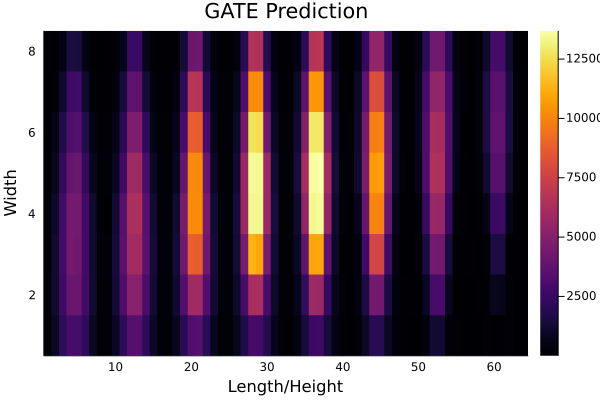

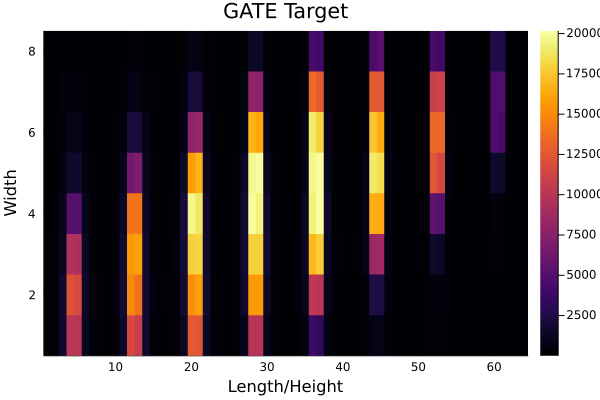

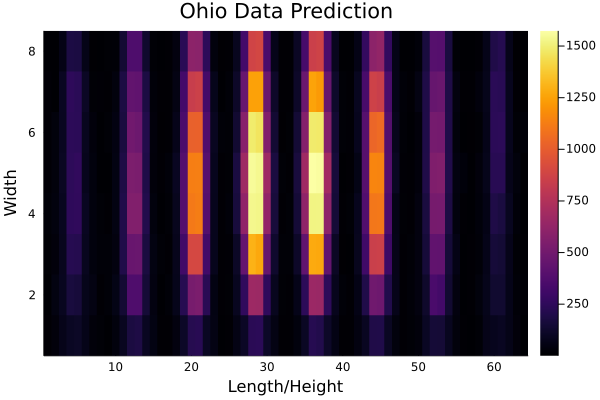

0.3736314731621575
20loss(trainingArray, targetArray) = 4.591482f6
loss(trainingArray, targetArray) = 4.2667165f6
loss(trainingArray, targetArray) = 4.0567762f6
loss(trainingArray, targetArray) = 3.8726005f6
loss(trainingArray, targetArray) = 3.7080738f6
loss(trainingArray, targetArray) = 3.5235275f6
loss(trainingArray, targetArray) = 3.353408f6
loss(trainingArray, targetArray) = 3.2174275f6


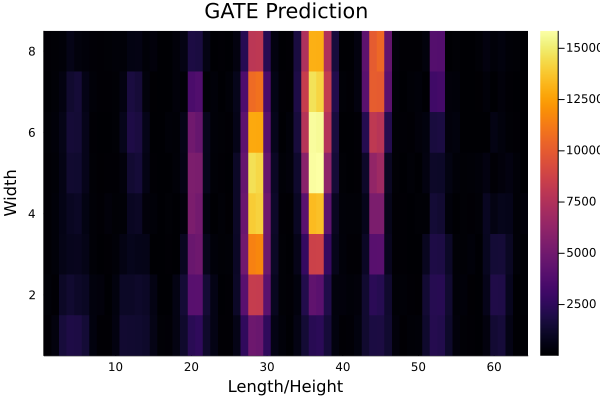

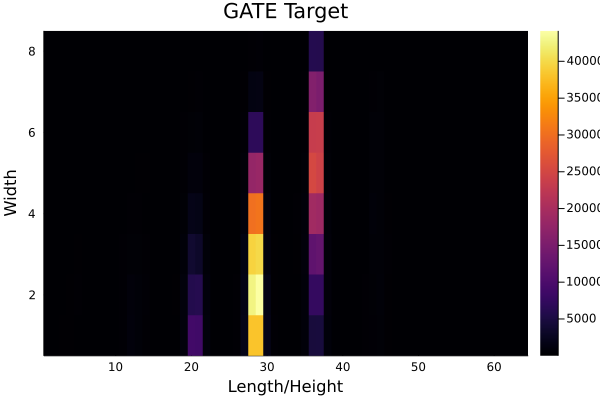

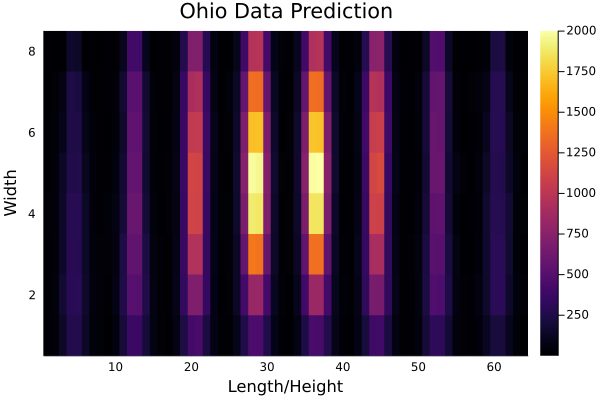

Training R2: 0.724522339866873
Validation R2: 0.43543845916354884
2loss(trainingArray, targetArray) = 3.1322218f6
loss(trainingArray, targetArray) = 3.0486195f6
loss(trainingArray, targetArray) = 2.9807642f6
loss(trainingArray, targetArray) = 2.9197035f6
loss(trainingArray, targetArray) = 2.8593555f6
loss(trainingArray, targetArray) = 2.7867832f6
loss(trainingArray, targetArray) = 2.7354102f6
loss(trainingArray, targetArray) = 2.6964285f6
loss(trainingArray, targetArray) = 2.6604298f6
loss(trainingArray, targetArray) = 2.6270045f6
Training R2: 

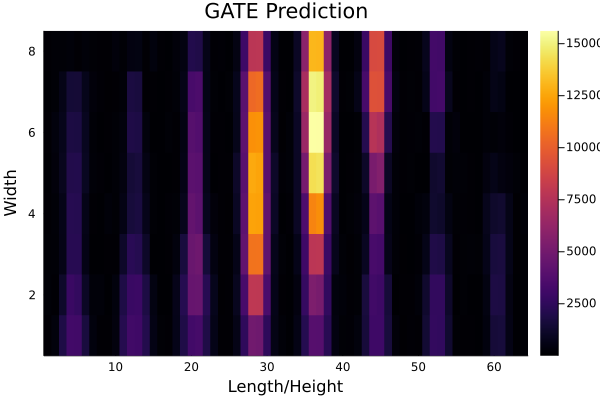

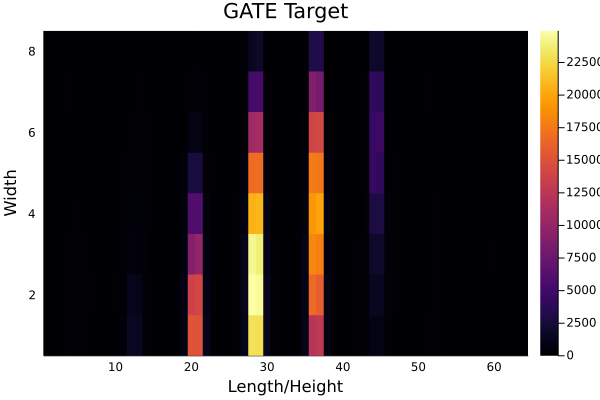

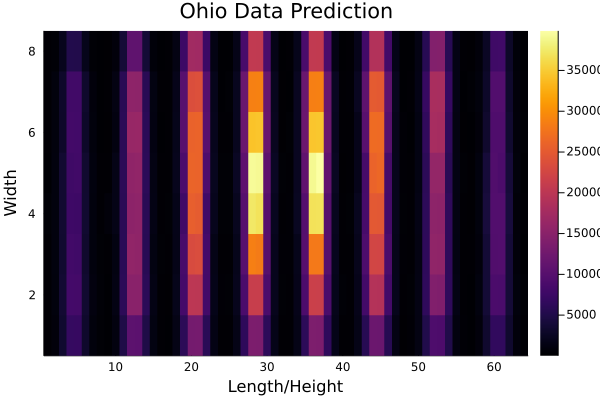

0.7900024678069328
Validation R2: 0.44498455530383096
14loss(trainingArray, targetArray) = 2.6237915f6
loss(trainingArray, targetArray) = 2.5927982f6
loss(trainingArray, targetArray) = 2.5636978f6
loss(trainingArray, targetArray) = 2.5336152f6
loss(trainingArray, targetArray) = 2.5053722f6
loss(trainingArray, targetArray) = 2.4811578f6
loss(trainingArray, targetArray) = 2.458212f6
loss(trainingArray, targetArray) = 2.436445f6
loss(trainingArray, targetArray) = 2.4157858f6
loss(trainingArray, targetArray) = 2.3961498f6


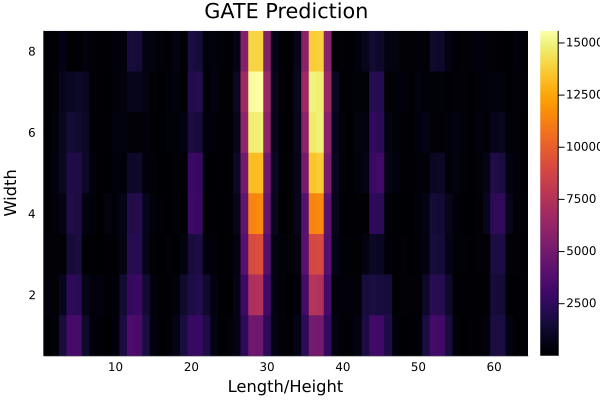

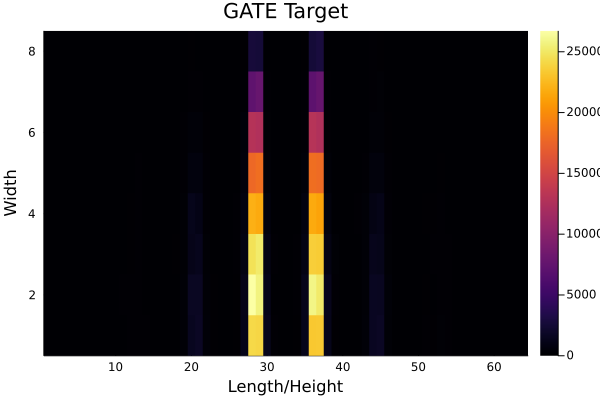

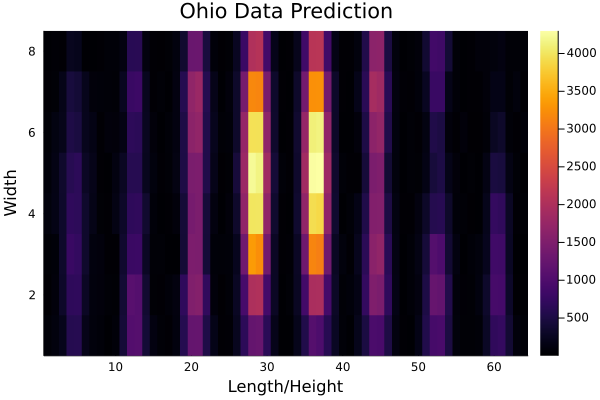

Training R2: 0.8207237269205641
Validation R2: 0.4538986462857715
5loss(trainingArray, targetArray) = 2.3811348f6
loss(trainingArray, targetArray) = 2.363179f6
loss(trainingArray, targetArray) = 2.3444055f6
loss(trainingArray, targetArray) = 2.3281682f6
loss(trainingArray, targetArray) = 2.31267f6
loss(trainingArray, targetArray) = 2.2978638f6
loss(trainingArray, targetArray) = 2.283739f6
loss(trainingArray, targetArray) = 2.2689355f6
loss(trainingArray, targetArray) = 2.2561395f6
loss(trainingArray, targetArray) = 2.2439608f6
Training R2: 0.8408903981932615
Validation R2: 

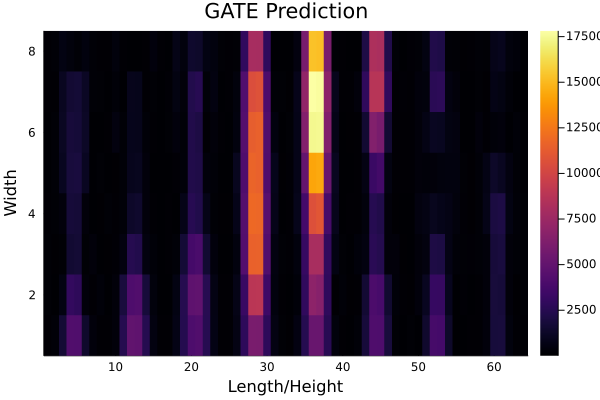

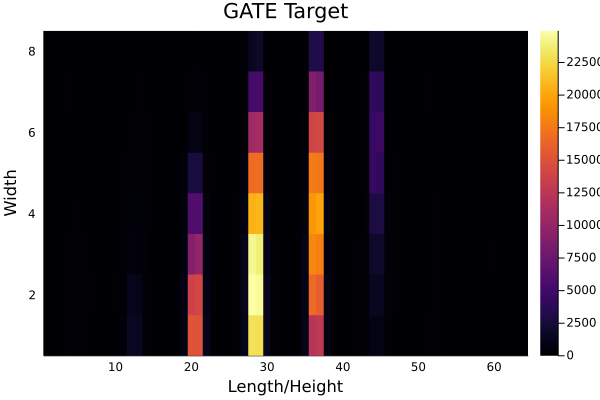

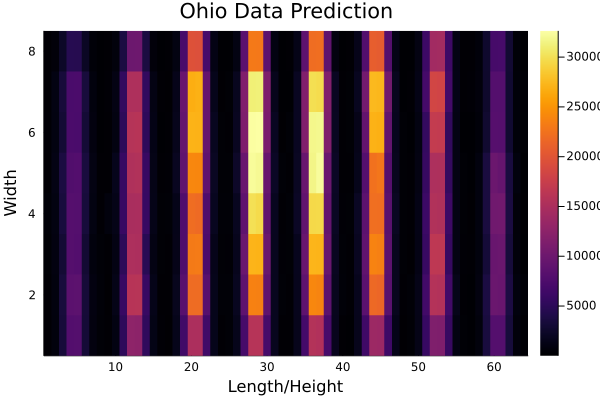

0.46295847467972673
14loss(trainingArray, targetArray) = 2.2346255f6
loss(trainingArray, targetArray) = 2.2223698f6
loss(trainingArray, targetArray) = 2.2117862f6
loss(trainingArray, targetArray) = 2.2017155f6
loss(trainingArray, targetArray) = 2.1911772f6
loss(trainingArray, targetArray) = 2.1820892f6
loss(trainingArray, targetArray) = 2.173437f6
loss(trainingArray, targetArray) = 2.1652062f6
loss(trainingArray, targetArray) = 2.1573838f6
loss(trainingArray, targetArray) = 2.1485165f6


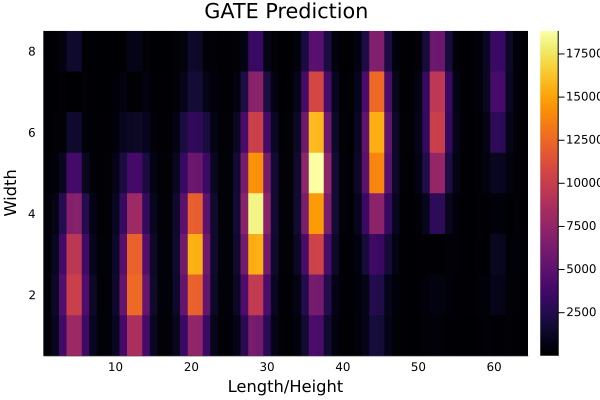

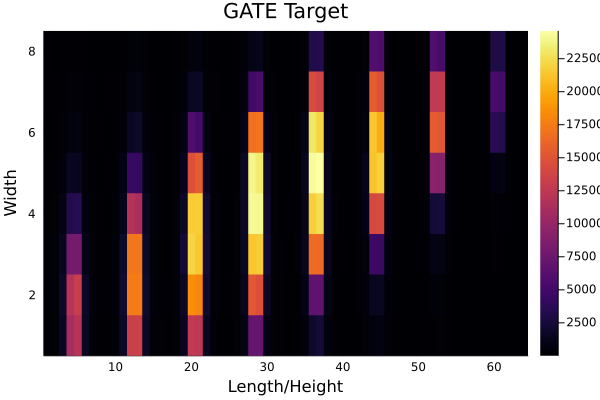

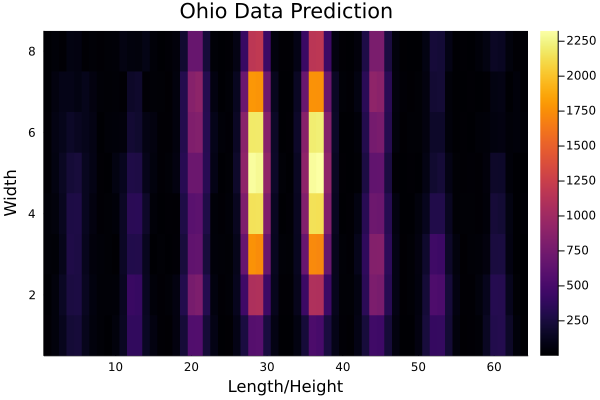

Training R2: 0.8561866596086374
Validation R2: 0.47029865679685834
16loss(trainingArray, targetArray) = 2.1442865f6
loss(trainingArray, targetArray) = 2.1355335f6
loss(trainingArray, targetArray) = 2.1285775f6
loss(trainingArray, targetArray) = 2.1225698f6
loss(trainingArray, targetArray) = 2.1168645f6
loss(trainingArray, targetArray) = 2.1114398f6
loss(trainingArray, targetArray) = 2.106255f6
loss(trainingArray, targetArray) = 2.101303f6
loss(trainingArray, targetArray) = 2.0961394f6
loss(trainingArray, targetArray) = 2.0916695f6


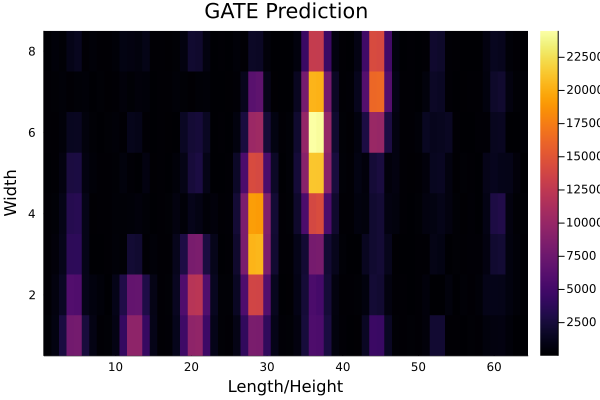

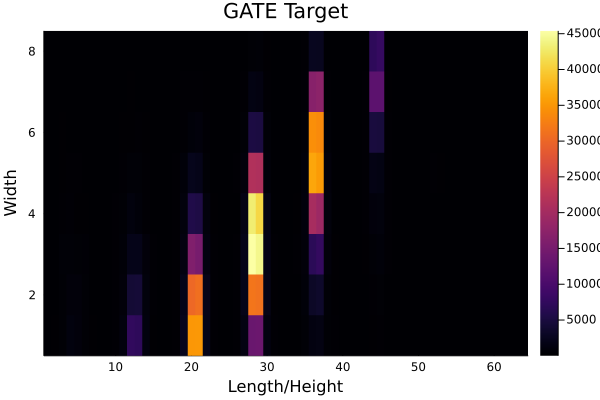

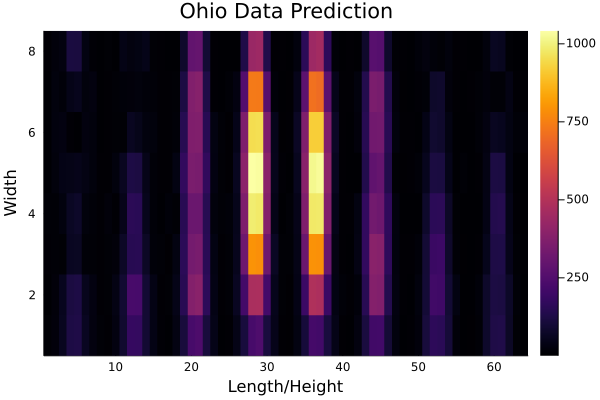

Training R2: 0.8666151173314028
Validation R2: 0.4764071043388992
3loss(trainingArray, targetArray) = 2.0895275f6
loss(trainingArray, targetArray) = 2.0845376f6
loss(trainingArray, targetArray) = 2.0786826f6
loss(trainingArray, targetArray) = 2.0738911f6
loss(trainingArray, targetArray) = 2.0690211f6
loss(trainingArray, targetArray) = 2.0647421f6
loss(trainingArray, targetArray) = 2.0615995f6
loss(trainingArray, targetArray) = 2.0582405f6


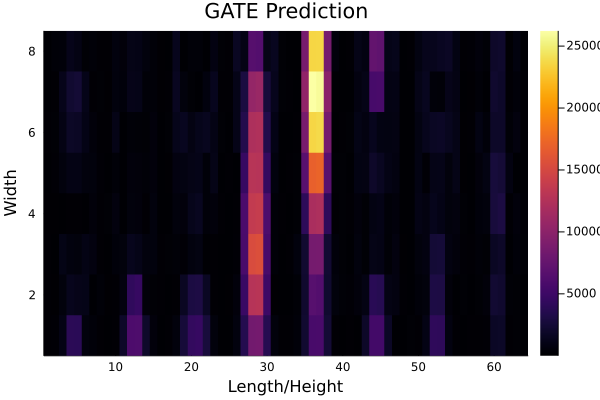

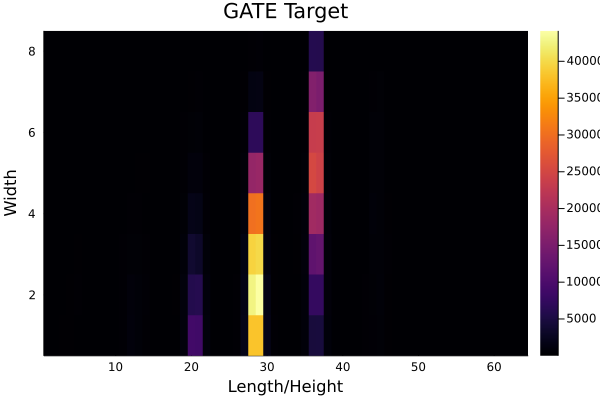

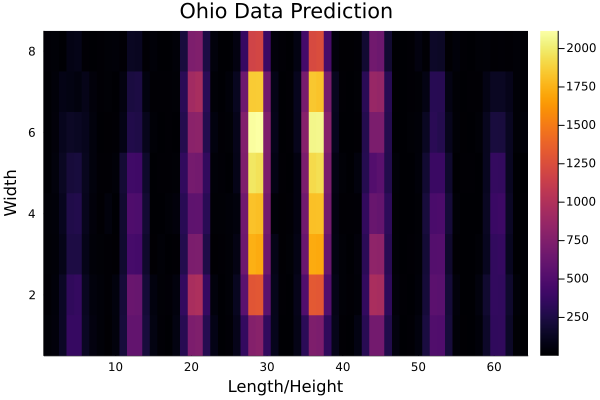

Training R2: 0.8733836954603484
Validation R2: 0.4825675500264295
2loss(trainingArray, targetArray) = 2.0547261f6
loss(trainingArray, targetArray) = 2.0516358f6
loss(trainingArray, targetArray) = 2.0489238f6
loss(trainingArray, targetArray) = 2.0462676f6
loss(trainingArray, targetArray) = 2.0437064f6
loss(trainingArray, targetArray) = 2.0412104f6
loss(trainingArray, targetArray) = 2.0387912f6
loss(trainingArray, targetArray) = 2.0364142f6
loss(trainingArray, targetArray) = 2.0341151f6
loss(trainingArray, targetArray) = 2.031875f6


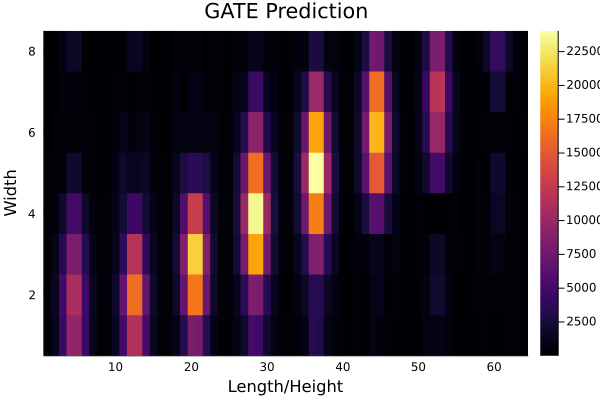

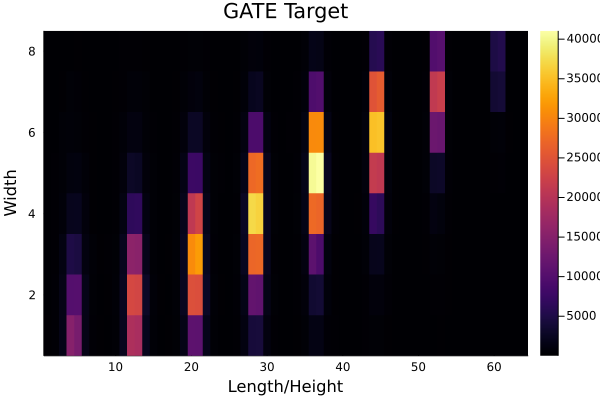

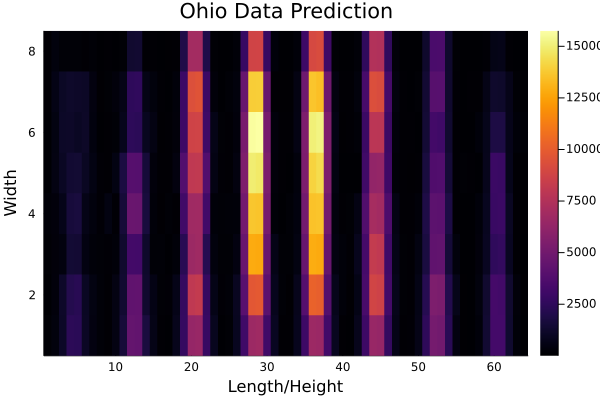

Training R2: 0.8778054050210805
Validation R2: 0.48914166714881424
8loss(trainingArray, targetArray) = 2.0299026f6
loss(trainingArray, targetArray) = 2.0277646f6
loss(trainingArray, targetArray) = 2.0256772f6
loss(trainingArray, targetArray) = 2.0236211f6
loss(trainingArray, targetArray) = 2.021614f6
loss(trainingArray, targetArray) = 2.0196514f6
loss(trainingArray, targetArray) = 2.0177255f6
loss(trainingArray, targetArray) = 2.0158451f6
loss(trainingArray, targetArray) = 2.0139979f6
loss(trainingArray, targetArray) = 2.0121928f6


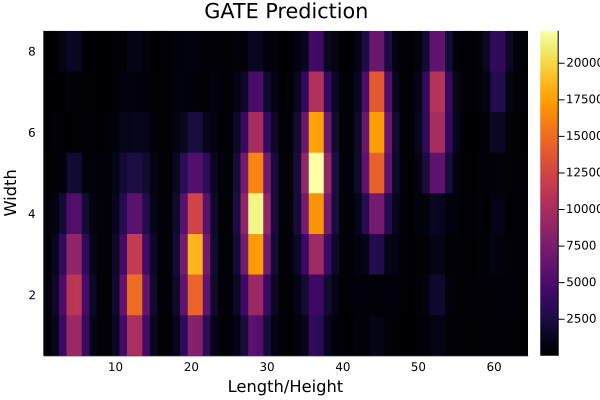

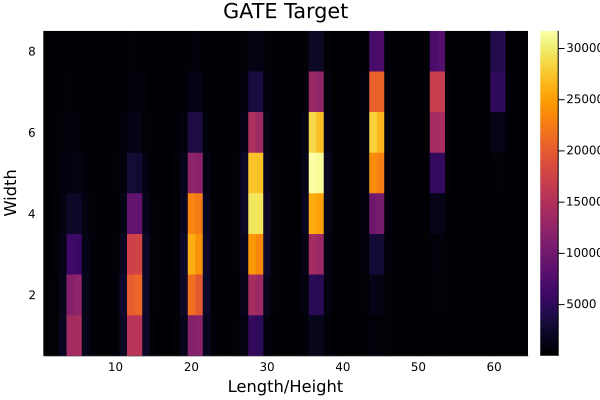

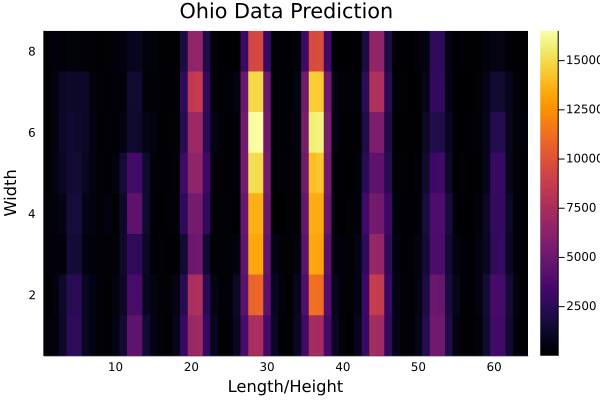

Training R2: 0.8808097634425834
Validation R2: 0.49624268619906453
12

In [41]:
for i = 1:10
    Flux.train!(loss, params(m), dataset, opt, cb = throttle(evalcb, 2))
    CurrentR2 = r2(lm(@formula(A  ~ B), DataFrame(A=Float64.(m(trainingArray)[:,1]), B=targetArray[:,1])))
    print("Training R2: ", CurrentR2, '\n')
    CurrentVR2 = r2(lm(@formula(A  ~ B), DataFrame(A=Float64.(m(validationArray)[:,1]), B=validationTargetArray[:,1])))
    print("Validation R2: ", CurrentVR2, '\n')
    print("\n\t")
    plotResults(m)
end

In [90]:
function writeOutput(m)
    readPath = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    readArray = filter(x->occursin(string("A000"), x), readdir(readPath))
    
    path = "/home/jupyter-nrmeskell/dosimeter/neural_nets/JuliaOutputs/NathanRuns"
    runNumber = lpad(size(readdir(path))[1], 3, "0")
    path = string(path, "/Run", runNumber, "R2-", lpad(Int(round(CurrentVR2, digits=3)*1000),3,"0"))
    mkdir(path)
    mkdir(string(path, "/fullSimulationOutputs"))
    mkdir(string(path, "/fullOhioOutputs"))
    for i = 1:size(validationTargetArray)[2]
        beamSize = filter(x->occursin(string("A000"), x), readdir(readPath))[div(100-1, div(size(validationTargetArray)[2],readSize))+1][1:8]
    
        writedlm(string(path,"/fullSimulationOutputs/ValidationTarget",lpad(i,3,"0"), "-", beamSize, ".txt"), reshape(validationTargetArray[:,i], (8*8,8)), " ")
        writedlm(string(path,"/fullSimulationOutputs/ValidationOutput",lpad(i,3,"0"), "-", beamSize, ".txt"), Int.(round.(reshape(m(validationArray)[:,i], (8*8,8)))), " ")
    end
    

    readPath = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    readArray = filter(x->occursin(string("A000"), x), readdir(readPath))
    for i = 1:size(inputArray)[4]
        writedlm(string(path,"/fullOhioOutputs/OhioOutput",lpad(i,3,"0"),".txt"), Int.(round.(reshape(m(inputArray)[:,i], (8*8,8)))), " ")
    end
end

writeOutput (generic function with 1 method)

In [91]:
writeOutput(m)